In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import clemb
import IPython.core.debugger
dbg = IPython.core.debugger.Pdb()


### Equations from Hurst et al., 1991
Energy balance for the lake:

$$
\frac{d}{dt}Q = Q_i - Q_e - cTM_o + cT_sM_s
$$

$Q$ = total energy of the lake

$T$ = temperature at any time $t$

$c$ = specific heat of lake water

$Q_i$ = heat input at the base of the lake

$Q_e$ = heat loss due to evaporation, radiation, solar heating (gain)

$M_o$ = total rate of outflow

$M_s$ = inflow rate from melt

$T_s$ = temperature of inflow

Assuming $T_s = 0 ^{\circ}C$:

$$
\begin{aligned}
\frac{d}{dt}Q & = Q_i - Q_e - cTM_o \\
              & = \frac{d}{dt}[cMT] \\
              & = cM\frac{dT}{dt} + cT\frac{dM}{dt}
\end{aligned}
$$

$$
\Rightarrow \qquad \frac{dT}{dt} = \frac{1}{cM}\left(Q_i - Q_e - cTM_o -cT\frac{dM}{dt}\right) 
$$

$M$ = mass of the water in the lake at time t

Mass balance:

$$
\frac{dM}{dt} = M_i + M_s - M_o - M_e
$$

$M_i$ = rate at which water or steam is added through the volcanic vent

$M_e$ = rate of evaporation losses

Ion concentration balance:

$$
\begin{aligned}
\frac{d}{dt}[MZ] & = Z_i M_i - Z M_o\\
\frac{dM}{dt} + M_o & = \frac{1}{Z} ( Z_i M_i - M \frac{dZ}{dt} ) 
\end{aligned}
$$

$Z$ = ion concentration in the lake

$Z_iM_i$ = rate of addition of ions through the lake bottom

If $Z_iM_i = 0$:

$$
\frac{dM}{dt} = -M_o - \frac{M}{Z}\frac{dZ}{dt}
$$

### Equations from code

Lake mass:

$$
\begin{aligned}
\rho & = 1.003 - 0.00033T \\
V & = f(h)\\
M & = V * \rho
\end{aligned}
$$
$\rho$ = density of lake water

$V$ = lake volume

$h$ = lake level

Outflow:

$$
M_o = M_n - M_{n-1} + M_{n-1} \left (0.98\frac{M_{n-1}Z_{n-1}}{M_nZ_n} -1.0 \right )
$$

Long wave radiation loss:

$$
\dot{E}_{long} = 5.67e^{-8}A[0.97(T - 1 + 273.15)^4 -  0.8(0.9 + 273.15)^4]
$$

$A$ = lake surface area

Free and forced convection:

$$
\begin{aligned}
\dot{E}_{evap} & = \\
&  A \sqrt{\left [ 2.2 (T - 1 - 0.9)^{\frac{1}{3}} (6.112e^{\frac{17.62(T-1)}{243.12(T-1)}} - 6.5) \right ] ^2+ \left [ \left ( 4.07e^{-3} \frac{w^{0.8}}{500^{0.2}} - \frac{1.107e^{-2}}{500} \right ) \left ( \frac{1}{800} ( 6.112e^{\frac{17.62(T-1)}{243.12(T-1)}} - 6.5) \right ) 2400000 \right ]^2}
\end{aligned}
$$

$w$ = wind speed

Solar heating:

$$
\dot{E}_{solar} = \Delta t A 1.5e^{-5} \left [ 1 + 0.5 cos \left (\frac{((m-1)3.14)}{6.0} \right ) \right ]
$$

$m$ = month of the year

Heat loss due to evaporation radiation and solar heating 

$$
Q_e = \dot{E}_{long} + \dot{E}_{evap} \left ( 1+0.948 \frac{1005}{2.4e^6} \frac{T - 1 - 0.9}{6.335e^{-3} + 6.718e^{-4}(T-1) -2.0887e^{-5}(T-1)^2 + 7.3095e^{-7}(T-1)^3 - 2.2e^{-3}} \right ) - \dot{E}_{solar}
$$

$$
M_e = \dot{E}_{evap}2.4e^{-12}
$$

In [2]:
def es(T, w, a):
    """
    Energy loss from lake surface in TJ/day. Equations apply for nominal
    surface area of 200000 square metres. Since area is only to a small
    power, this error is negligible.
    """
    # Assumptions:
    # Characteristic length of lake is 500 m
    l = 500
    # Surface temperature about 1 C less than bulk water
    ts = T - 1.0
    # Air temperature is 0.9 C
    t_air = 0.9
    # Saturation vapour pressure at air temperature = 6.5 mBar and
    # humidity around 50%. This is slightly less than 6.577 posted on
    # the Hyperphysics site
    vp_air = 6.5
    # Saturation vapour density at ambient conditions
    vd_air = 0.0022
    # Atmospheric pressure is 800 mBar at Crater Lake
    pa = 800.
    # Specific heat of air 1005 J/kg
    ca = 1005
    # Air density .948 kg/m^3
    da = .948
    # Latent heat of vapourization about 2400 kJ/kg in range 20 - 60 C,
    lh = 2400000.
    # Expressions for H2O properties as function of temperature
    # Saturation vapour Pressure Function from CIMO Guide (WMO, 2008)
    vp = 6.112 * np.exp(17.62 * ts / (243.12 + ts))
    # Saturation vapour Density from Hyperphysics Site
    vd = .006335 + .0006718 * ts - .000020887 * \
         ts * ts + .00000073095 * ts * ts * ts

    # First term is for radiation, Power(W) = CA(e_wTw^4 - e_aTa^4)
    # Temperatures absolute, a is emissivity, C Stefans Constant
    tk = ts + 273.15
    tl = t_air + 273.15
    er = 5.67E-8 * a * (0.97 * tk**4 - 0.8 * tl**4)

    # Free convection formula from Adams et al(1990)
    # Power (W) = A * factor * delT^1/3 * (es-ea)

    efree = a * 2.2 * (ts - t_air) ** (1 / 3.0) * (vp - vp_air)

    # Forced convection by Satori's Equation
    # Evaporation (kg/s/m2) =
    # (0.00407 * W**0.8 / L**0.2 - 0.01107/L)(es-ea)/pa

    eforced = a * (0.00407 * w**0.8 / l**0.2 - 0.01107 / l) * \
        (vp - vp_air) / pa * lh  # W

    ee = np.sqrt(efree**2 + eforced**2)

    # The ratio of Heat Loss by Convection to that by Evaporation is
    # rhoCp/L * (Tw - Ta)/(qw - qa) #rho is air density .948 kg/m3, Cp
    ratio = da * (ca / lh) * (ts - t_air) / (vd - vd_air)

    # The power calculation is in W. Calculate Energy Loss (TW/day) and
    # evaporative volume loss in kT/day
    ev = 86400 * ee / 2.4e12  # kT/day
    loss = (er + ee * (1 + ratio)) * 86400 * 1.0e-12  # TW/day
    return loss, ev

In [3]:
def fullness(h):
    vol = 4.747475 * np.power(h, 3) - 34533.8 * np.power(h, 2) + 83773360. * h - 67772125000.
    h += 1.0
    v1 = 4.747475 * np.power(h, 3) - 34533.8 * np.power(h, 2) + 83773360. * h - 67772125000.
    a = v1 - vol
    vol /= 1000.
    return a, vol

In [4]:
def esol(time, a, datetime):
    """
    Solar Incident Radiation Based on yearly guess & month.
    """
    pesol = a * 0.000015 * (1 + 0.5 * np.cos(((datetime[int(time)].month - 1) * 3.14) / 6.0))
    return pesol

In [5]:
# Second-order Runge-Kutta
def rk2 (y, time, dt, derivs, **kargs) :
    k0 = dt * derivs(y, time, **kargs)
    k1 = dt * derivs(y + k0, time + dt, **kargs)
    y_next = y + 0.5 * (k0 + k1)
    return y_next

# Fourth-order Runge-Kutta
def rk4(y, time, dt, derivs, **kargs):
    k0 = dt * derivs(y, time, **kargs)
    k1 = dt * derivs(y + 0.5 * k0, time + 0.5 * dt, **kargs)
    k2 = dt * derivs(y + 0.5 * k1, time + 0.5 * dt, **kargs)
    k3 = dt * derivs(y + k2, time + dt, **kargs)
    y_next = y + 1./6.*(k0 + 2 * k1 + 2 * k2 + k3)
    return y_next

def euler(y, time, dt, derivs, **kargs):
    k0 = dt * derivs(y, time, **kargs)
    y_next = y + k0
    return y_next

In [6]:
def dT(state, time, datetime=0., index=0., dll=lambda x: 0.,
       dmi=lambda x: 0., dms=lambda x: 0.):
    cw = 0.0042
    ws = 4.5
    density = 1.003 - 0.00033 * state[3]
    a, vol = fullness(state[2])
    enth = 6.0
    mass = vol*density
    qe, me = es(state[3], ws, a)
    factor = state[3]*cw/(enth - state[3]*cw)
    ms = state[1]
    qi = state[0] - ms*state[3]*cw
    g0 = dmi(index)
    g1 = dms(index)
    g2 = dll(index)
    g3 = 1./(cw*vol)*(-qe + esol(time, a, datetime)  + qi)
    return np.array([g0, g1, g2, g3])
   

In [7]:
def error(y1, y2, t1, t2):
    f1 = interp1d(t1, y1)
    err = y2 - f1(t2)
    return err

In [8]:
if True:
    c = clemb.Clemb(clemb.LakeDataFITS(), clemb.WindDataCSV(), start='2016-01-02 ', end='2017-11-27')

In [9]:
if True:
    rp = c.run([0,1])
    s = pd.HDFStore('clemb_output.h5')
    s['df'] = rp
    s.close()

In [10]:
s = pd.HDFStore('clemb_output.h5')
df = s['df']
s.close()

<IPython.core.display.Javascript object>


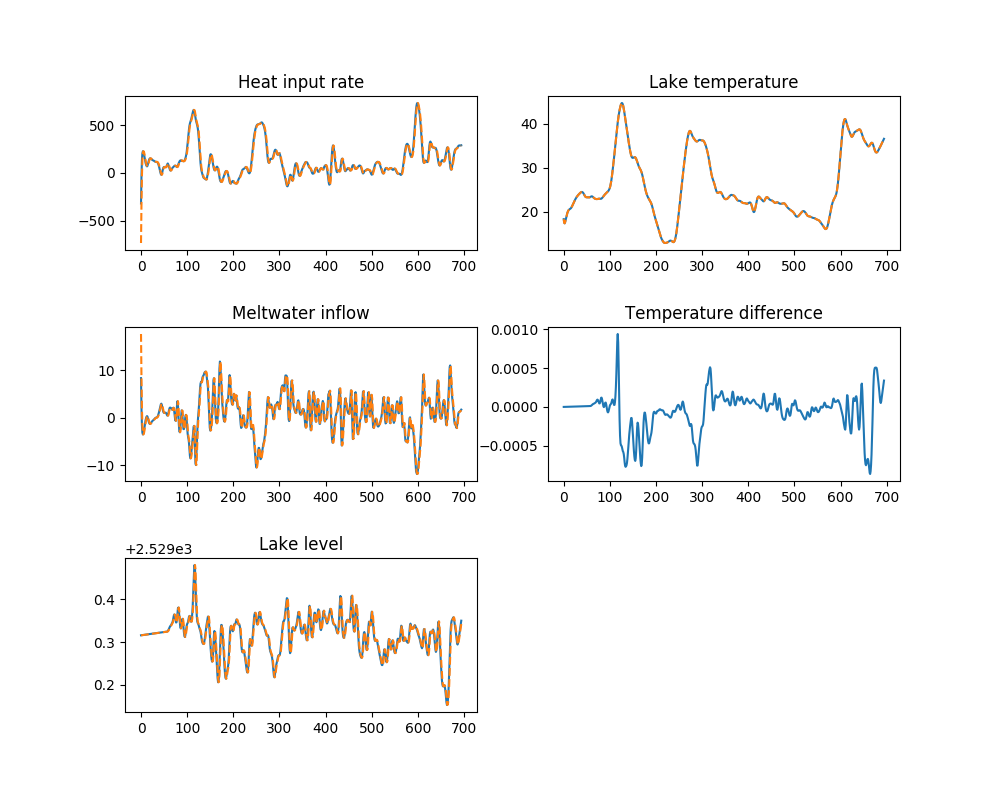

In [20]:
def evaluate_forward_model():
    startdate = '2016-01-01'
    pwr = df.loc[0,'pwr']*0.0864
    pwr = pwr.loc[pwr.index > startdate]
    datetime = pwr.index
    pwr_grad = np.zeros(pwr.index.size)
    pwr_grad[0:-2] = np.diff(pwr.values[1::])
    pwr_grad[-2] = pwr_grad[-3]
    time_orig = np.arange(pwr.index.size)
    def f_mi(index):
        return f_mi.func[index]
    f_mi.func = pwr_grad[:]
 
    melt = df.loc[0,'fmelt']
    melt = melt.loc[melt.index > startdate]
    melt_grad = np.zeros(melt.index.size)
    melt_grad[0:-2] = np.diff(melt.values[1::])
    melt_grad[-2] = melt_grad[-3]
    def f_ms(index):
        return f_ms.func[index]
    f_ms.func = melt_grad[:]

    ll = df.loc[0,'llvl']
    ll = ll.loc[ll.index > startdate]
    ll_grad = np.zeros(ll.index.size)
    ll_grad[0:-2] = np.diff(ll.values[1::])
    ll_grad[-2] = ll_grad[-3]
    def f_ll(index):
        return f_ll.func[index]
    f_ll.func = ll_grad
       
    t = df.loc[0,'t']
    t = t.loc[t.index > startdate]

    ndays = (datetime[-1] - datetime[0]).days
    dt = 1.
    nsteps = int(ndays/float(dt))
    time = np.linspace(0,ndays,nsteps+1)
    T0 = t.values[0]
    Mi0 = pwr.values[1]
    Ms0 = melt.values[1]
    Ll0 = ll.values[1]
    y = np.zeros((nsteps+1, 4))
    y[0] = [Mi0, Ms0, Ll0, T0]
    for i in range(nsteps):
        y[i+1] = euler(y[i], i*dt, dt, dT, 
                       index=int(i*dt), datetime=datetime,
                       dll=f_ll,  dmi=f_mi, dms=f_ms)

    mpl.rcParams['figure.subplot.hspace'] = 0.5
    plt.figure(figsize=(10,8))
    ax1 = plt.subplot(3,2,1)
    ax1.plot(time, y[:,0]/0.0864)
    ax1.plot(time, pwr.values/0.0864, ls='--')
    ax1.set_title('Heat input rate')
    
    ax2 = plt.subplot(3,2,3)
    ax2.plot(time, y[:,1])
    ax2.plot(time, melt.values, ls='--')
    ax2.set_title('Meltwater inflow')
    
    ax3 = plt.subplot(3,2,5)
    ax3.plot(time, y[:,2])
    ax3.plot(time, ll.values[:], ls='--')
    ax3.set_title('Lake level')
    
    ax4 = plt.subplot(3,2,2)
    ax4.plot(time, y[:,3])
    ax4.plot(time, t.values[:], ls='--')
    ax4.set_title('Lake temperature')
    
    ax5 = plt.subplot(3,2,4)
    ax5.plot(time_orig, error(y[:,3], t.values[:], time, time_orig))
    ax5.set_title('Temperature difference')
evaluate_forward_model()

### Synthetic input

In [21]:
# matplotlib.rcParams['axes.prop_cycle']
cl1 = '#1f77b4'
cl2 = '#ff7f0e'
cl3 = '#2ca02c'

In [22]:
def dT1(state, time, datetime=0., dll=lambda x: 0.,
       dqi=lambda x: 0., dms=lambda x: 0.):
    cw = 0.0042
    ws = 4.5
    density = 1.003 - 0.00033 * state[3]
    a, vol = fullness(state[2])
    enth = 6.0
    mass = vol*density
    qe, me = es(state[3], ws, a)
    factor = state[3]*cw/(enth - state[3]*cw)
    ms = state[1]
    qi = state[0] - ms*state[3]*cw
    mi = qi/(enth - cw*state[3])
    mi += ms*factor
    ms *= (1.0 + factor)
    mout = ms + mi - me
    g0 = dqi(time)
    g1 = dms(time)
    g2 = dll(time)
    g3 = 1./(cw*mass)*(-qe + esol(time, a, datetime)  + qi - cw*state[3]*mout)
    return np.array([g0, g1, g2, g3])

<IPython.core.display.Javascript object>


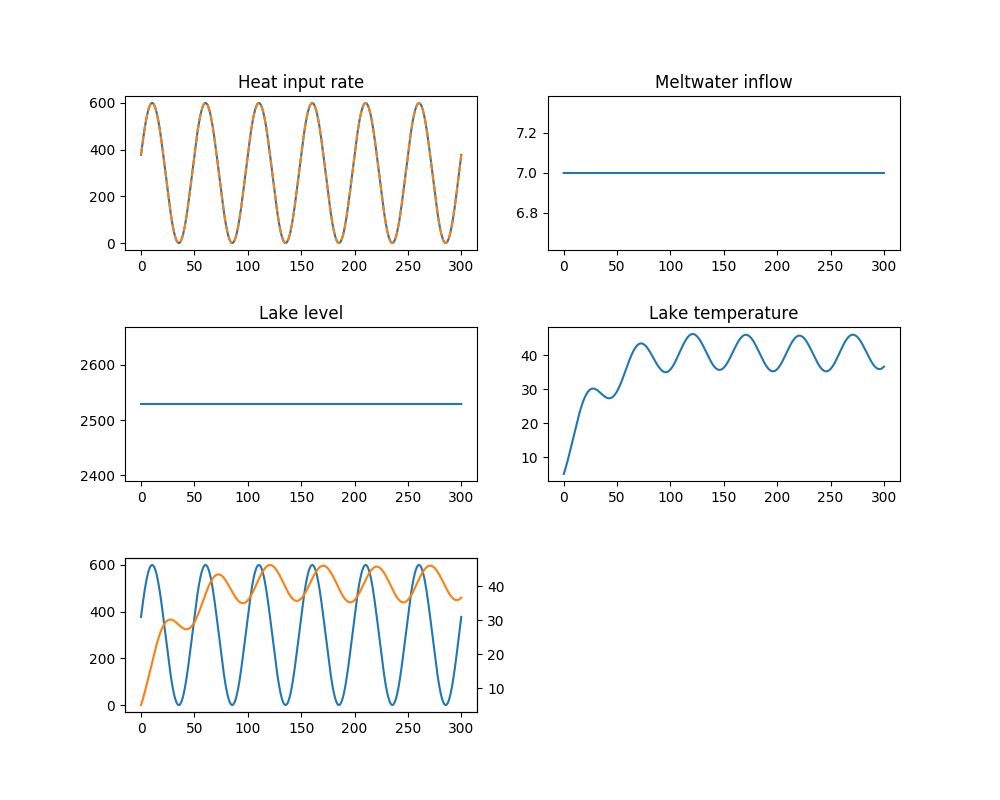

In [23]:
f = 0.02
nsteps = 2001
tmax = 300.
t = np.linspace(0, tmax, nsteps)
dt = tmax/(nsteps-1)
qi = np.sin(2.*np.pi*f*t + np.deg2rad(15))*300.+300.
qi *= 0.0864
dqi = lambda t: 0.0864*300*np.cos(2.*np.pi*f*t + np.deg2rad(15))*2.*np.pi*f

datetime = pd.date_range('1/1/2017', periods=nsteps+1, freq='D')
y = np.zeros((nsteps, 4))
y[0] = [qi[0], 7., 2529, 5.]
for i in range(nsteps-1):
    y[i+1] = rk4(y[i], i*dt, dt, dT1, datetime=datetime,
                dqi=dqi)

mpl.rcParams['figure.subplot.hspace'] = 0.5
plt.figure(figsize=(10,8))
ax1 = plt.subplot(3,2,1)
ax1.plot(t, y[:,0]/0.0864)
ax1.plot(t, qi/0.0864, ls='--')
ax1.set_title('Heat input rate')

ax2 = plt.subplot(3,2,2)
ax2.plot(t, y[:,1])
ax2.set_title('Meltwater inflow')

ax3 = plt.subplot(3,2,3)
ax3.plot(t, y[:,2])
ax3.set_title('Lake level')

ax4 = plt.subplot(3,2,4)
ax4.plot(t, y[:,3])
ax4.set_title('Lake temperature')

ax5 = plt.subplot(3,2,5)
ax5.plot(t, y[:,0]/0.0864)
ax6 = ax5.twinx()
ax6.plot(t, y[:,3], color=cl2)
